In [ ]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_pd = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Feature selected X(MF_MF_Full data).csv")

In [ ]:
X_pd

,0,1,2,6,18,19,23,34,99,127,...,175,176,199,204,213,294,300,301,304,305
0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17500.0,1.06,82.81,1.0
1,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17500.0,1.06,80.00,1.0
2,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,78800.0,1.12,0.10,1.0
3,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22100.0,1.03,1.02,1.0
4,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13500.0,1.06,4.35,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,1.50,0.10,0.0
4829,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,1.50,0.10,0.0
4830,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,1.50,0.10,0.0
4831,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,1.50,0.10,0.0


In [ ]:
y_pd = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Training_data(MF_MF_full data).csv").iloc[:, -1]

In [ ]:
y_pd

0       21.34
1       21.18
2       73.99
3       27.42
4        6.08
        ...  
4828    63.14
4829    71.08
4830    72.63
4831    73.50
4832    73.50
Name: CP(°C), Length: 4833, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X = X_pd.values
y = y_pd.values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [ ]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
# import pickle

# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_trained_model(feature selected)(MF_MF_Full data).pkl', mode='wb') as f:
#   pickle.dump(gp,f)

# **Feature Importance**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
sort = model.feature_importances_.argsort()
plt.barh(f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

NotFittedError: ignored

For Polymer
bit 93


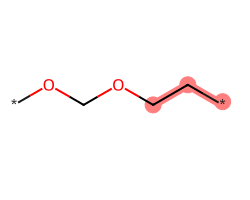

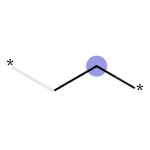

For Solvent
bit 147


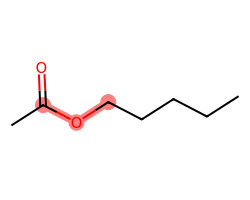

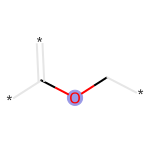

For Polymer
bit 80


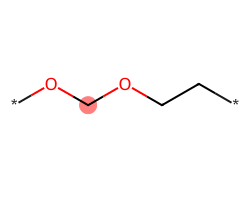

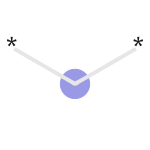

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = [93, "147*", 80]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

Shap of Botorch

In [ ]:
import pickle
with open("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_trained_model(feature selected)(MF_MF_Full data).pkl", mode="rb") as m:
  gp = pickle.load(m)

In [ ]:
class shap_model:
    def __init__(self, model):
        self.model = model
        return
    def predict(self, X):
        X_tensor = torch.from_numpy(np.array(X))
        return self.model.posterior(X_tensor).mean.detach().numpy().copy()

In [ ]:
from sklearn.metrics import r2_score

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

AttributeError: ignored

In [ ]:
import shap
#The model for KernelExplainer should be a function that has ability to transfer input data to some output data.

gp_shap = shap_model(gp)
gp_ex = shap.KernelExplainer(gp_shap.predict, X_train)
shap_values = gp_ex.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

  0%|          | 0/3866 [00:00<?, ?it/s]

# **Feature Selection**

Low Variance Filter

In [ ]:
from copy import copy

thresheld = 0.1  #10%

data = copy(pd.DataFrame(X)) #only check X variables
var = data.var()
X_col = data.columns
variable = X_col[var >=thresheld] #find columns to keep
data = data[variable]

print (data.shape)

(4833, 61)


High Correlation Filter

In [ ]:
#Filter Method is the first step to perform when selecting features.
from copy import copy

thresheld = 0.8

# data = copy(fp_com) #Stacking with low variance filter
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #using 'where' and input array to choose a specific cell in dataframe
to_drop = [column for column in upper.columns if any(upper[column] >= thresheld)] #find columns to drop
data = data.drop(columns = to_drop) 

print (data.shape)

(4833, 27)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
data.to_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Training Data/Feature selected data(MF_MF_No 1-Phase).csv', index=False)

Calculate performance after feature selection

In [ ]:
from sklearn.model_selection import train_test_split

X = data.values
y = df_new["CP(°C)"].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#Using randomforestregressor
rf_new = RandomForestRegressor()
rf_new.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf_new.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf_new.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf_new.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf_new.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8457592154659479
RMSE(Train): 30.409364540164802

R_square(Test): 0.7948313463178673
RMSE(Test): 34.49695267466584


In [ ]:
rmse_sum['RF_feature selected'] = [RMSE_train, RMSE_test]
r2_sum['RF_feature selected'] = [R_square_train, R_square_test] 

Text(0.5, 0, 'Feature Importance')

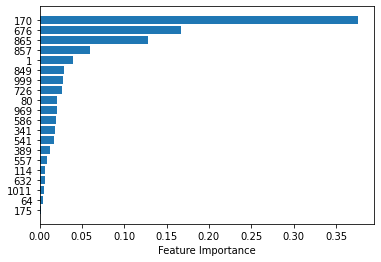

In [ ]:
model = rf_new
sort = model.feature_importances_.argsort()
plt.barh(fp_com.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

In [ ]:
new_list = [int(s) for s in list(reversed(fp_com.columns[sort].astype(str)[-20:].to_list()))[:5]]
new_list

[170, 676, 865, 857, 1]

For Polymer
bit 170


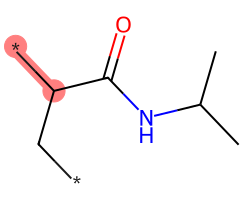

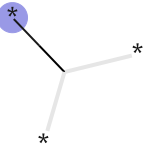

For Polymer
bit 676


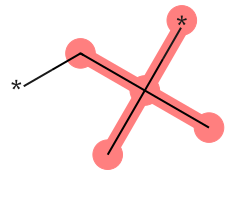

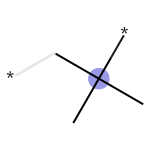

For Polymer
bit 865


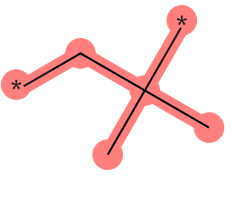

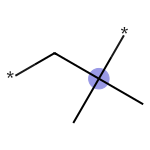

For Polymer
bit 857


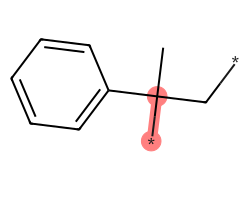

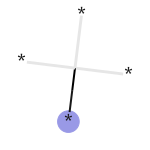

For Polymer
bit 1


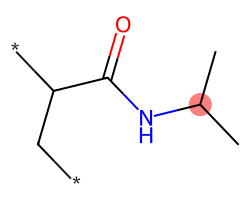

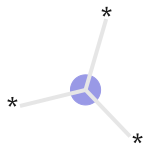

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = new_list
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)